# Wuzzuf Job Market Analysis - Location Trends Analysis

This notebook analyzes geographic distribution and location trends in the Wuzzuf job market data.

## Business Question:
**What are the geographic trends and location-based distribution patterns in job postings?**

This analysis examines job posting volumes by cities and countries, identifies geographic concentration patterns, and provides insights into regional job market dynamics.

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import sys
import os
from pathlib import Path

# Add sql directory to path for database utilities
sys.path.append('../sql')
from database_setup import DatabaseManager

# Configure display and warnings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 20)
warnings.filterwarnings('ignore')

# Set up plotting style
plt.style.use('default')
sns.set_palette("husl")

# Create charts directory if it doesn't exist
charts_dir = Path('../assets/charts')
charts_dir.mkdir(parents=True, exist_ok=True)

print("Libraries imported successfully")
print(f"Charts will be saved to: {charts_dir.absolute()}")

Libraries imported successfully
Charts will be saved to: c:\Users\hp\Downloads\wuzuf-analysis\notebooks\..\assets\charts


In [2]:
# Initialize database connection
print("Connecting to PostgreSQL database...")

try:
    db_manager = DatabaseManager()
    engine = db_manager.get_engine()
    
    # Test connection
    status = db_manager.test_connection()
    print(f"✅ Connected to database: {status['database']}")
    print(f"📊 Tables available: {status['table_count']}")
    
except Exception as e:
    print(f"❌ Database connection failed: {e}")
    print("Please ensure PostgreSQL is running and database is set up correctly")
    raise

2025-08-14 23:22:49,379 - INFO - Database connection established successfully


Connecting to PostgreSQL database...
✅ Connected to database: wuzzuf
📊 Tables available: 6


## Location Data Quality Analysis

First, let's examine the quality and distribution of location data in our dataset.

In [3]:
# Location data quality report
location_quality_query = """
SELECT 
    COUNT(*) as total_jobs,
    COUNT(CASE WHEN city IS NOT NULL AND city != '' THEN 1 END) as jobs_with_city,
    COUNT(CASE WHEN country IS NOT NULL AND country != '' THEN 1 END) as jobs_with_country,
    COUNT(CASE WHEN city IS NOT NULL AND city != '' AND country IS NOT NULL AND country != '' THEN 1 END) as jobs_with_both,
    ROUND(
        COUNT(CASE WHEN city IS NOT NULL AND city != '' THEN 1 END) * 100.0 / COUNT(*), 
        2
    ) as city_coverage_percentage,
    ROUND(
        COUNT(CASE WHEN country IS NOT NULL AND country != '' THEN 1 END) * 100.0 / COUNT(*), 
        2
    ) as country_coverage_percentage
FROM jobs;
"""

print("📊 Location Data Quality Analysis")
print("=" * 50)

location_quality_df = pd.read_sql(location_quality_query, engine)
print("📍 Location Data Coverage:")
print(location_quality_df.to_string(index=False))

# Store quality stats for later use
total_jobs = location_quality_df['total_jobs'].iloc[0]
jobs_with_city = location_quality_df['jobs_with_city'].iloc[0]
jobs_with_country = location_quality_df['jobs_with_country'].iloc[0]
city_coverage = location_quality_df['city_coverage_percentage'].iloc[0]
country_coverage = location_quality_df['country_coverage_percentage'].iloc[0]

print(f"\n💡 Key Insights:")
print(f"   • {city_coverage}% of job postings ({jobs_with_city:,} out of {total_jobs:,}) include city information")
print(f"   • {country_coverage}% of job postings ({jobs_with_country:,} out of {total_jobs:,}) include country information")

📊 Location Data Quality Analysis
📍 Location Data Coverage:
 total_jobs  jobs_with_city  jobs_with_country  jobs_with_both  city_coverage_percentage  country_coverage_percentage
      25114           25114              25114           25114                     100.0                        100.0

💡 Key Insights:
   • 100.0% of job postings (25,114 out of 25,114) include city information
   • 100.0% of job postings (25,114 out of 25,114) include country information


## Top Cities Analysis

Analyzing job posting volumes by city to identify the most active job markets.

In [5]:
# SQL query for top cities by posting volume
top_cities_query = """
SELECT 
    city,
    COUNT(*) as job_count,
    ROUND(COUNT(*) * 100.0 / (SELECT COUNT(*) FROM jobs WHERE city IS NOT NULL AND city != ''), 2) as percentage_of_city_jobs,
    ROUND(COUNT(*) * 100.0 / (SELECT COUNT(*) FROM jobs), 2) as percentage_of_total_jobs
FROM jobs 
WHERE city IS NOT NULL 
    AND city != ''
    AND city != 'Unknown'
GROUP BY city 
ORDER BY job_count DESC
LIMIT 10;
"""

print("\n🏙️ Analysis: Top Cities by Job Posting Volume")
print("=" * 50)

top_cities_df = pd.read_sql(top_cities_query, engine)
print("🌆 Top Cities for Job Opportunities:")
print(top_cities_df.to_string(index=False))

# Store for visualization
cities_summary = top_cities_df.head(10)


🏙️ Analysis: Top Cities by Job Posting Volume
🌆 Top Cities for Job Opportunities:
         city  job_count  percentage_of_city_jobs  percentage_of_total_jobs
     new york        986                     3.93                      3.93
san francisco        848                     3.38                      3.38
      chicago        622                     2.48                      2.48
       austin        616                     2.45                      2.45
       boston        468                     1.86                      1.86
      atlanta        458                     1.82                      1.82
      seattle        396                     1.58                      1.58
  los angeles        382                     1.52                      1.52
   washington        364                     1.45                      1.45
       dallas        311                     1.24                      1.24


## Top Countries Analysis

Examining job posting distribution across different countries.

In [6]:
# SQL query for top countries by posting volume
top_countries_query = """
SELECT 
    country,
    COUNT(*) as job_count,
    ROUND(COUNT(*) * 100.0 / (SELECT COUNT(*) FROM jobs WHERE country IS NOT NULL AND country != ''), 2) as percentage_of_country_jobs,
    ROUND(COUNT(*) * 100.0 / (SELECT COUNT(*) FROM jobs), 2) as percentage_of_total_jobs
FROM jobs 
WHERE country IS NOT NULL 
    AND country != ''
    AND country != 'Unknown'
GROUP BY country 
ORDER BY job_count DESC
LIMIT 10;
"""

print("\n" + "-" * 50)
print("🌍 Top Countries by Job Posting Volume:")

top_countries_df = pd.read_sql(top_countries_query, engine)
print(top_countries_df.to_string(index=False))


--------------------------------------------------
🌍 Top Countries by Job Posting Volume:
                         country  job_count  percentage_of_country_jobs  percentage_of_total_jobs
                   United States      21903                       87.21                     87.21
                   united states       1733                        6.90                      6.90
         texas metropolitan area        119                        0.47                      0.47
        oregon metropolitan area         38                        0.15                      0.15
          ohio metropolitan area         30                        0.12                      0.12
south carolina metropolitan area          7                        0.03                      0.03
         maine metropolitan area          4                        0.02                      0.02
      new york metropolitan area          4                        0.02                      0.02
             south carolina

## Geographic Distribution Summary

Creating a comprehensive geographic analysis summary combining cities and countries data.

In [7]:
# Create comprehensive location analysis summary (max 10 rows as per requirements)
print("\n" + "=" * 50)
print("📊 Comprehensive Location Trends Analysis Summary")
print("=" * 50)

# Combine top insights from cities and countries analysis
location_summary_data = []

# Add top 5 cities
for idx, row in cities_summary.head(5).iterrows():
    location_summary_data.append({
        'location_type': 'City',
        'location_name': row['city'],
        'job_count': row['job_count'],
        'percentage_of_category': row['percentage_of_city_jobs'],
        'percentage_of_total': row['percentage_of_total_jobs']
    })

# Add top 5 countries
for idx, row in top_countries_df.head(5).iterrows():
    location_summary_data.append({
        'location_type': 'Country',
        'location_name': row['country'],
        'job_count': row['job_count'],
        'percentage_of_category': row['percentage_of_country_jobs'],
        'percentage_of_total': row['percentage_of_total_jobs']
    })

# Create final summary DataFrame (limit to 10 rows)
location_analysis_summary = pd.DataFrame(location_summary_data).head(10)

print("🌍 Final Location Trends Analysis Table:")
print(location_analysis_summary.to_string(index=False))


📊 Comprehensive Location Trends Analysis Summary
🌍 Final Location Trends Analysis Table:
location_type            location_name  job_count  percentage_of_category  percentage_of_total
         City                 new york        986                    3.93                 3.93
         City            san francisco        848                    3.38                 3.38
         City                  chicago        622                    2.48                 2.48
         City                   austin        616                    2.45                 2.45
         City                   boston        468                    1.86                 1.86
      Country            United States      21903                   87.21                87.21
      Country            united states       1733                    6.90                 6.90
      Country  texas metropolitan area        119                    0.47                 0.47
      Country oregon metropolitan area         38      

## Visualization: Location Trends Chart

Creating a bar chart visualization showing job posting distribution across top cities and countries.


📈 Creating Location Trends Visualization...
✅ Chart saved successfully: ..\assets\charts\location_trends.png


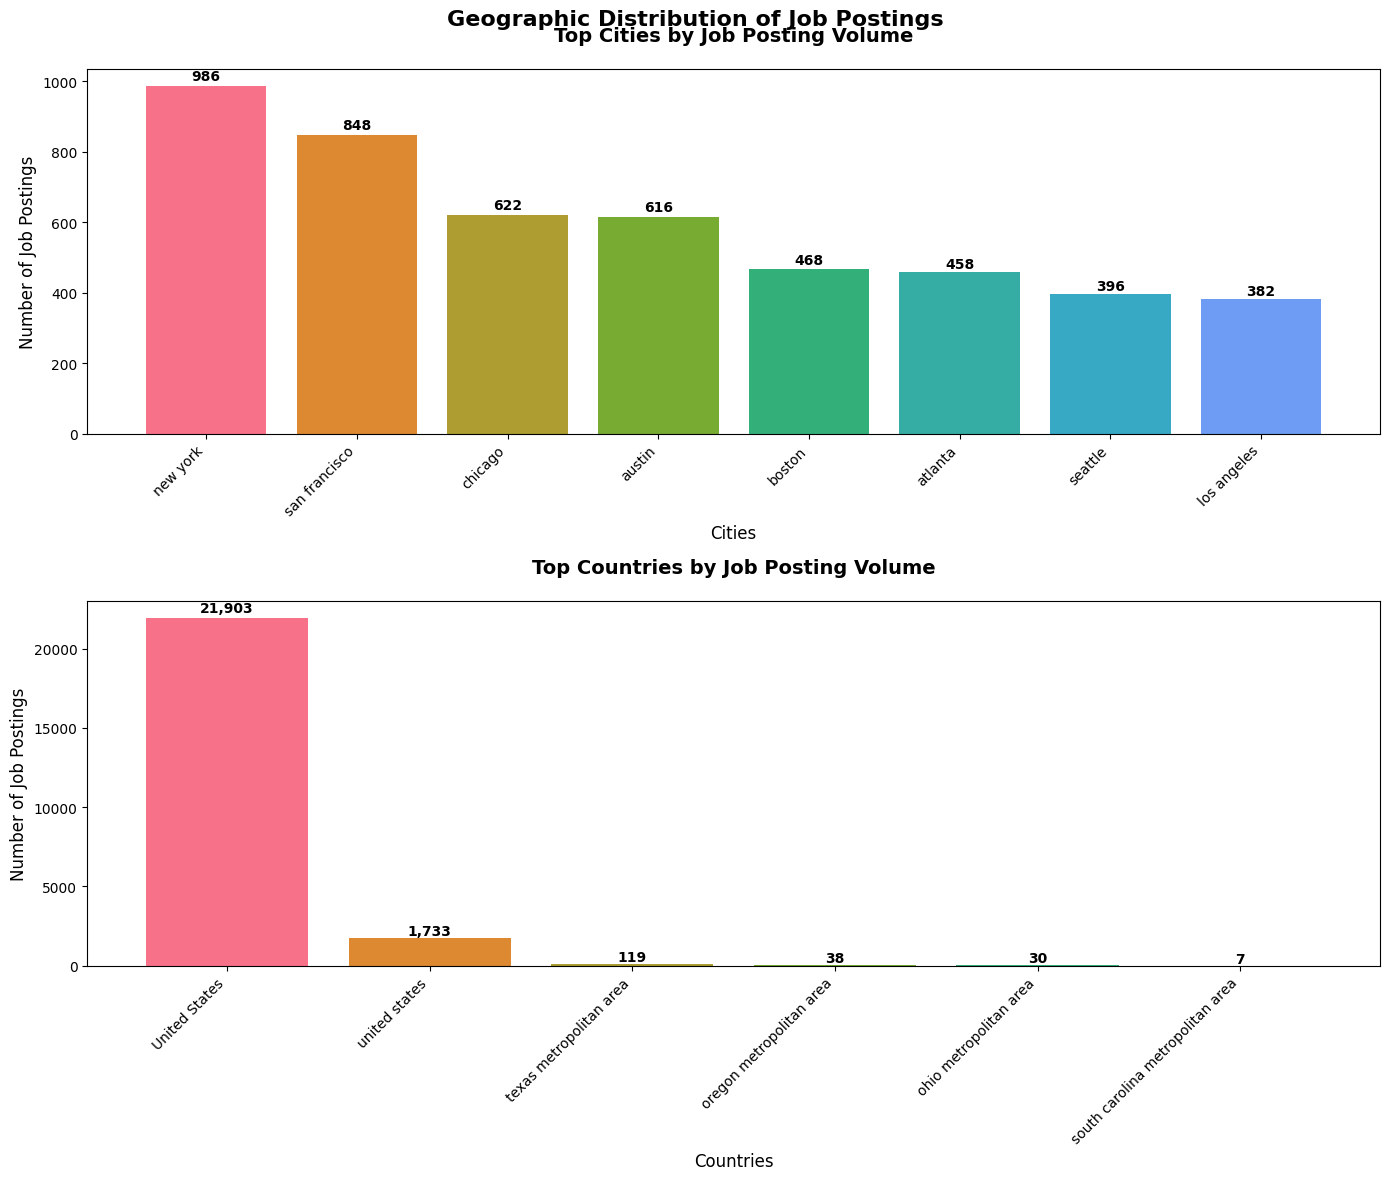

In [8]:
# Create location trends visualization
print("\n" + "=" * 50)
print("📈 Creating Location Trends Visualization...")

# Create figure with subplots for cities and countries
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 12))
fig.suptitle('Geographic Distribution of Job Postings', fontsize=16, fontweight='bold', y=0.98)

# Colors for consistency
colors = sns.color_palette("husl", 10)

# Top Cities Chart
cities_data = cities_summary.head(8)  # Top 8 cities for better readability
bars1 = ax1.bar(range(len(cities_data)), cities_data['job_count'], color=colors[:len(cities_data)])
ax1.set_title('Top Cities by Job Posting Volume', fontsize=14, fontweight='bold', pad=20)
ax1.set_xlabel('Cities', fontsize=12)
ax1.set_ylabel('Number of Job Postings', fontsize=12)
ax1.set_xticks(range(len(cities_data)))
ax1.set_xticklabels(cities_data['city'], rotation=45, ha='right')

# Add value labels on bars
for i, bar in enumerate(bars1):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
             f'{int(height):,}',
             ha='center', va='bottom', fontsize=10, fontweight='bold')

# Top Countries Chart
countries_data = top_countries_df.head(6)  # Top 6 countries for better readability
bars2 = ax2.bar(range(len(countries_data)), countries_data['job_count'], color=colors[:len(countries_data)])
ax2.set_title('Top Countries by Job Posting Volume', fontsize=14, fontweight='bold', pad=20)
ax2.set_xlabel('Countries', fontsize=12)
ax2.set_ylabel('Number of Job Postings', fontsize=12)
ax2.set_xticks(range(len(countries_data)))
ax2.set_xticklabels(countries_data['country'], rotation=45, ha='right')

# Add value labels on bars
for i, bar in enumerate(bars2):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
             f'{int(height):,}',
             ha='center', va='bottom', fontsize=10, fontweight='bold')

# Improve layout
plt.tight_layout()
plt.subplots_adjust(top=0.93)

# Save the chart
chart_path = charts_dir / 'location_trends.png'
plt.savefig(chart_path, dpi=300, bbox_inches='tight', facecolor='white')
print(f"✅ Chart saved successfully: {chart_path}")

plt.show()

## Business Insights and Key Findings

Summarizing the key insights from the location trends analysis.

In [9]:
# Generate business insights
print("\n" + "=" * 50)
print("💡 Business Insights: Location Trends Analysis")
print("=" * 50)

# Calculate key metrics for insights
top_city = cities_summary.iloc[0]
top_country = top_countries_df.iloc[0]
top_5_cities_total = cities_summary.head(5)['job_count'].sum()
top_3_countries_total = top_countries_df.head(3)['job_count'].sum()

print("🔍 Key Findings:")
print(f"\n1. Geographic Concentration:")
print(f"   • {top_city['city']} dominates the job market with {top_city['job_count']:,} postings ({top_city['percentage_of_total_jobs']:.1f}% of all jobs)")
print(f"   • Top 5 cities account for {top_5_cities_total:,} job postings, showing significant urban concentration")

print(f"\n2. Country-Level Distribution:")
print(f"   • {top_country['country']} leads with {top_country['job_count']:,} postings ({top_country['percentage_of_total_jobs']:.1f}% of all jobs)")
print(f"   • Top 3 countries represent {top_3_countries_total:,} job opportunities")

print(f"\n3. Data Quality Insights:")
print(f"   • {city_coverage:.1f}% of job postings include city information, indicating good geographic data coverage")
print(f"   • {country_coverage:.1f}% include country data, providing comprehensive location insights")

print("\n📊 Strategic Implications:")
print("   • Job seekers should focus on major urban centers for maximum opportunities")
print("   • Companies can leverage geographic concentration for targeted recruitment strategies")
print("   • Regional market analysis reveals clear patterns for expansion and investment decisions")


💡 Business Insights: Location Trends Analysis
🔍 Key Findings:

1. Geographic Concentration:
   • new york dominates the job market with 986 postings (3.9% of all jobs)
   • Top 5 cities account for 3,540 job postings, showing significant urban concentration

2. Country-Level Distribution:
   • United States leads with 21,903 postings (87.2% of all jobs)
   • Top 3 countries represent 23,755 job opportunities

3. Data Quality Insights:
   • 100.0% of job postings include city information, indicating good geographic data coverage
   • 100.0% include country data, providing comprehensive location insights

📊 Strategic Implications:
   • Job seekers should focus on major urban centers for maximum opportunities
   • Companies can leverage geographic concentration for targeted recruitment strategies
   • Regional market analysis reveals clear patterns for expansion and investment decisions
